In [287]:
# data loading and pre-processing similar to part 1
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

# Loading the dataset
dataset = pd.read_csv('dataset.csv')

# Handling invalid characters
dataset_cleaned = dataset.map(lambda x: pd.to_numeric(x, errors='coerce')).dropna()

X = dataset_cleaned.drop('target', axis=1)
y = dataset_cleaned['target']

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the dataset
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# creating dataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [289]:
# defining model
class NeuralNetwork(nn.Module):
    def __init__(self, dropout_value=0.3):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(7, 64),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)


In [335]:

# model training
def train_model(model, train_loader, val_loader, loss_function, optimizer, epochs=50):
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(epochs):
        #training
        model.train()
        correct_train, total_train = 0, 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            predicted = torch.round(outputs)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        
        # evaluating
        model.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                predicted = torch.round(outputs)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

    return train_accuracies, val_accuracies

# helper function for evaluating model
def evaluate_model(model, test_loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = torch.round(outputs)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    test_accuracy = correct / total
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
    return test_accuracy




In [359]:
# step 1 & 2
#: Tuning "Dropout, Batch Size & Optimizer" hyperparameter

dropout_values = [0.2, 0.3, 0.5]
dropout_results = []

for dropout in dropout_values:
    model = NeuralNetwork(dropout_value=dropout)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    loss_function = nn.BCELoss()
    
    train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, loss_function, optimizer, epochs=50)
    test_accuracy = evaluate_model(model, test_loader)
    
    dropout_results.append({'Dropout': dropout, 'Test Accuracy': round(test_accuracy * 100, 2)})

# creating DataFrame
dropout_results_df = pd.DataFrame(dropout_results)
dropout_results_df.index += 1

print("\n Hyperparameter: Dropout")
dropout_results_df


Epoch 1, Train Accuracy: 0.3985, Val Accuracy: 0.3772
Epoch 2, Train Accuracy: 0.4417, Val Accuracy: 0.5263
Epoch 3, Train Accuracy: 0.5150, Val Accuracy: 0.5877
Epoch 4, Train Accuracy: 0.6391, Val Accuracy: 0.6491
Epoch 5, Train Accuracy: 0.6654, Val Accuracy: 0.6491
Epoch 6, Train Accuracy: 0.7143, Val Accuracy: 0.6579
Epoch 7, Train Accuracy: 0.7180, Val Accuracy: 0.6579
Epoch 8, Train Accuracy: 0.7049, Val Accuracy: 0.6667
Epoch 9, Train Accuracy: 0.7143, Val Accuracy: 0.6842
Epoch 10, Train Accuracy: 0.7199, Val Accuracy: 0.6842
Epoch 11, Train Accuracy: 0.7331, Val Accuracy: 0.6930
Epoch 12, Train Accuracy: 0.7086, Val Accuracy: 0.6930
Epoch 13, Train Accuracy: 0.7143, Val Accuracy: 0.6930
Epoch 14, Train Accuracy: 0.7387, Val Accuracy: 0.6930
Epoch 15, Train Accuracy: 0.7293, Val Accuracy: 0.7018
Epoch 16, Train Accuracy: 0.7368, Val Accuracy: 0.6930
Epoch 17, Train Accuracy: 0.7331, Val Accuracy: 0.7018
Epoch 18, Train Accuracy: 0.7500, Val Accuracy: 0.6930
Epoch 19, Train Acc

,Dropout,Test Accuracy
1,0.2,76.32
2,0.3,77.19
3,0.5,78.95


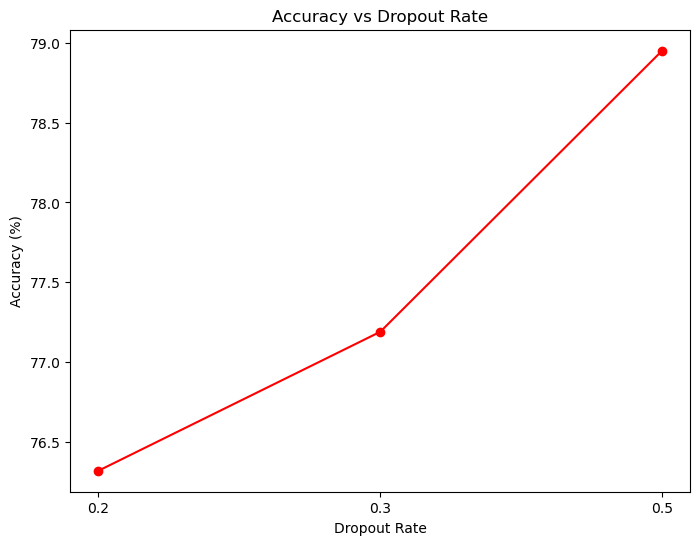

In [843]:
# plotting Dropout rate comparison
plt.figure(figsize=(8, 6))
dropouts = ['0.2', '0.3', '0.5']
dropout_accuracies = [76.32, 77.19, 78.95]
plt.plot(dropouts, dropout_accuracies, marker='o', linestyle='-', color='red')
plt.xlabel('Dropout Rate')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Dropout Rate')
plt.show()

In [361]:
# Tuning Batch Size
batch_sizes = [32, 64, 128]
batch_size_results = []

for batch_size in batch_sizes:
    # dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    model = NeuralNetwork(dropout_value=0.3)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    loss_function = nn.BCELoss()
    
    train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, loss_function, optimizer, epochs=50)
    test_accuracy = evaluate_model(model, test_loader)
    
    batch_size_results.append({'Batch Size': batch_size, 'Test Accuracy': round(test_accuracy * 100, 2)})

# creating dataFrame
batch_size_results_df = pd.DataFrame(batch_size_results)
batch_size_results_df.index += 1

# displaying
print("\n Hyperparameter: Batch Size")
batch_size_results_df

Epoch 1, Train Accuracy: 0.6786, Val Accuracy: 0.6930
Epoch 2, Train Accuracy: 0.7030, Val Accuracy: 0.7018
Epoch 3, Train Accuracy: 0.7049, Val Accuracy: 0.7018
Epoch 4, Train Accuracy: 0.7199, Val Accuracy: 0.7105
Epoch 5, Train Accuracy: 0.7312, Val Accuracy: 0.7193
Epoch 6, Train Accuracy: 0.7199, Val Accuracy: 0.7018
Epoch 7, Train Accuracy: 0.7575, Val Accuracy: 0.6930
Epoch 8, Train Accuracy: 0.7500, Val Accuracy: 0.7105
Epoch 9, Train Accuracy: 0.7613, Val Accuracy: 0.7193
Epoch 10, Train Accuracy: 0.7838, Val Accuracy: 0.7193
Epoch 11, Train Accuracy: 0.7744, Val Accuracy: 0.7368
Epoch 12, Train Accuracy: 0.7857, Val Accuracy: 0.7368
Epoch 13, Train Accuracy: 0.7857, Val Accuracy: 0.7456
Epoch 14, Train Accuracy: 0.7669, Val Accuracy: 0.7368
Epoch 15, Train Accuracy: 0.7820, Val Accuracy: 0.7456
Epoch 16, Train Accuracy: 0.7876, Val Accuracy: 0.7456
Epoch 17, Train Accuracy: 0.7707, Val Accuracy: 0.7456
Epoch 18, Train Accuracy: 0.7970, Val Accuracy: 0.7368
Epoch 19, Train Acc

,Batch Size,Test Accuracy
1,32,75.44
2,64,73.68
3,128,76.32


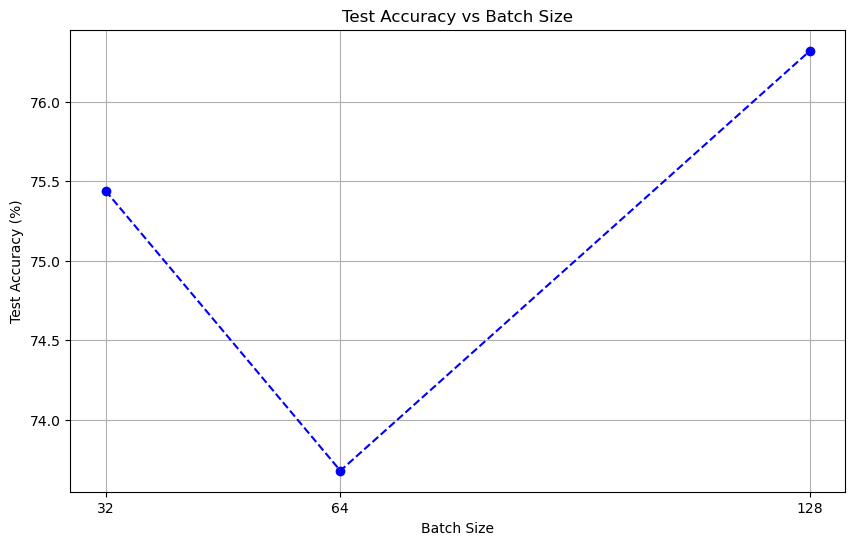

In [845]:
# Plotting Test Accuracy vs. Batch Size
plt.figure(figsize=(10, 6))
plt.plot(batch_size_results_df['Batch Size'], batch_size_results_df['Test Accuracy'], marker='o', linestyle='--', color='b')
plt.title('Test Accuracy vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Test Accuracy (%)')
plt.grid(True)
plt.xticks(batch_size_results_df['Batch Size'])
plt.show()

In [363]:
# Tuning Optimizer
optimizers = ['Adam', 'SGD', 'RMSprop']
optimizer_results = []

for optimizer_name in optimizers:
    model = NeuralNetwork(dropout_value=0.3)

    #optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.0005)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.0005)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.0006)
    
    loss_function = nn.BCELoss()

    #calculating accuracies
    train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, loss_function, optimizer, epochs=50)
    test_accuracy = evaluate_model(model, test_loader)
    
    optimizer_results.append({'Optimizer': optimizer_name, 'Test Accuracy(%)': round(test_accuracy * 100, 2)})

optimizer_results_df = pd.DataFrame(optimizer_results)
optimizer_results_df.index += 1

# displaying
print("\n Hyperparameter: Optimizer")
optimizer_results_df


Epoch 1, Train Accuracy: 0.6617, Val Accuracy: 0.6491
Epoch 2, Train Accuracy: 0.6823, Val Accuracy: 0.6491
Epoch 3, Train Accuracy: 0.6748, Val Accuracy: 0.6491
Epoch 4, Train Accuracy: 0.7237, Val Accuracy: 0.6667
Epoch 5, Train Accuracy: 0.6936, Val Accuracy: 0.6491
Epoch 6, Train Accuracy: 0.7162, Val Accuracy: 0.6667
Epoch 7, Train Accuracy: 0.6898, Val Accuracy: 0.6667
Epoch 8, Train Accuracy: 0.7293, Val Accuracy: 0.6842
Epoch 9, Train Accuracy: 0.7086, Val Accuracy: 0.6930
Epoch 10, Train Accuracy: 0.7237, Val Accuracy: 0.6930
Epoch 11, Train Accuracy: 0.7462, Val Accuracy: 0.6930
Epoch 12, Train Accuracy: 0.7312, Val Accuracy: 0.7018
Epoch 13, Train Accuracy: 0.7406, Val Accuracy: 0.6930
Epoch 14, Train Accuracy: 0.7425, Val Accuracy: 0.6930
Epoch 15, Train Accuracy: 0.7707, Val Accuracy: 0.6930
Epoch 16, Train Accuracy: 0.7669, Val Accuracy: 0.7018
Epoch 17, Train Accuracy: 0.7538, Val Accuracy: 0.6930
Epoch 18, Train Accuracy: 0.7669, Val Accuracy: 0.6930
Epoch 19, Train Acc

,Optimizer,Test Accuracy(%)
1,Adam,75.44
2,SGD,65.79
3,RMSprop,76.32


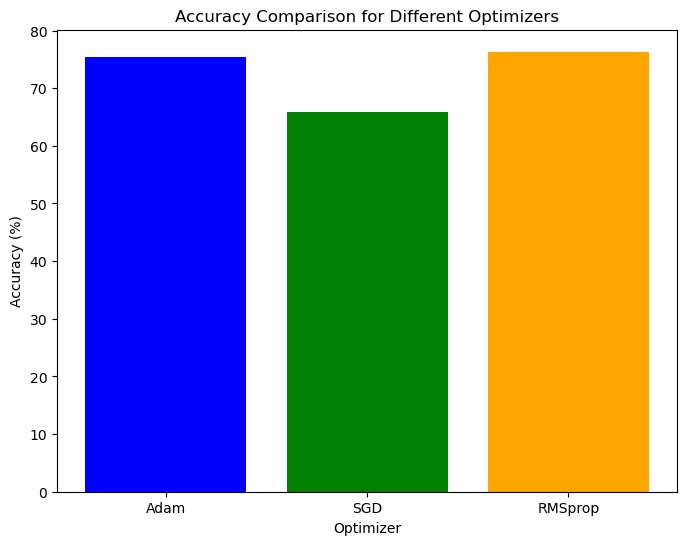

In [841]:
# plotting Optimizer
plt.figure(figsize=(8, 6))
optimizers = ['Adam', 'SGD', 'RMSprop']
optimizer_accuracies = [75.44, 65.79, 76.32]
plt.bar(optimizers, optimizer_accuracies, color=['blue', 'green', 'orange'])
plt.xlabel('Optimizer')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison for Different Optimizers')
plt.show()

In [853]:
# step 3
# Defining the base model by using hyperparameter that give best accuracy
# Dropout = 0.5, Batch size = 128 and Opitmizer = RMSprop

# base model (with dropout=0.5)
class NeuralNetwork(nn.Module):
    def __init__(self, dropout_value=0.5):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(7, 64),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# Defining Base Model Configuration
model = NeuralNetwork(dropout_value=0.5)
optimizer = optim.RMSprop(model.parameters(), lr=0.0005)
loss_function = nn.BCELoss()

# Loading the dataset with batch size 128
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Base Model Training Function
def train_base_model(model, train_loader, val_loader, loss_function, optimizer, epochs=50):
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

# evaluating the model
def evaluate_model(model, test_loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = correct / total
    return test_accuracy

# Training it for 50 epochs
train_base_model(model, train_loader, val_loader, loss_function, optimizer, epochs=50)

# printing the test accuracy of the Base Model
test_accuracy_base_model = evaluate_model(model, test_loader)
print(f"Base Model Test Accuracy (before improvements): {test_accuracy_base_model * 100:.2f}%")


Base Model Test Accuracy (before improvements): 76.32%


In [865]:
# Part 2: Step 4 
# Improving the base model

# Early stopping with the base model (dropout=0.5, batch_size=128, optimizer = RMSprop)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# function for Training model with Early Stopping 
def training_with_early_stopping(model, train_loader, val_loader, loss_function, optimizer, patience=5, epochs=50):
    best_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                val_loss += loss_function(outputs, labels).item()

        print(f"Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

# new model
improved_model_early_stopping = NeuralNetwork(dropout_value=0.5)
optimizer = optim.RMSprop(improved_model_early_stopping.parameters(), lr=0.0005)
loss_function = nn.BCELoss()

# training with Early Stopping
training_with_early_stopping(improved_model_early_stopping, train_loader, val_loader, loss_function, optimizer, patience=5, epochs=50)
test_accuracy_early_stopping = evaluate_model(improved_model_early_stopping, test_loader)

print(f"Test Accuracy with Early Stopping: {test_accuracy_early_stopping * 100:.2f}%")


Epoch 1, Validation Loss: 0.6374
Epoch 2, Validation Loss: 0.6168
Epoch 3, Validation Loss: 0.6011
Epoch 4, Validation Loss: 0.5875
Epoch 5, Validation Loss: 0.5752
Epoch 6, Validation Loss: 0.5649
Epoch 7, Validation Loss: 0.5539
Epoch 8, Validation Loss: 0.5455
Epoch 9, Validation Loss: 0.5387
Epoch 10, Validation Loss: 0.5313
Epoch 11, Validation Loss: 0.5266
Epoch 12, Validation Loss: 0.5219
Epoch 13, Validation Loss: 0.5185
Epoch 14, Validation Loss: 0.5158
Epoch 15, Validation Loss: 0.5132
Epoch 16, Validation Loss: 0.5113
Epoch 17, Validation Loss: 0.5096
Epoch 18, Validation Loss: 0.5098
Epoch 19, Validation Loss: 0.5085
Epoch 20, Validation Loss: 0.5069
Epoch 21, Validation Loss: 0.5054
Epoch 22, Validation Loss: 0.5027
Epoch 23, Validation Loss: 0.5018
Epoch 24, Validation Loss: 0.5009
Epoch 25, Validation Loss: 0.5006
Epoch 26, Validation Loss: 0.4993
Epoch 27, Validation Loss: 0.4984
Epoch 28, Validation Loss: 0.4989
Epoch 29, Validation Loss: 0.4991
Epoch 30, Validation Lo

In [825]:
# Learning rate scheduler with base model configuration
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Training function
def train_model_with_scheduler(model, train_loader, val_loader, loss_function, optimizer, scheduler, epochs=50):
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        correct_train = 0
        total_train = 0
        train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate training loss
            train_loss += loss.item()

            # Calculating training accuracy
            predicted_train = torch.round(outputs)
            correct_train += (predicted_train == labels).sum().item()
            total_train += labels.size(0)

        # Calculate and store the average training loss
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy * 100)

        # Validation phase
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                val_loss += loss.item()

                predicted_val = torch.round(outputs)
                correct_val += (predicted_val == labels).sum().item()
                total_val += labels.size(0)

        # Calculating and storing the average validation loss
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy * 100)

        # Updating learning rate
        scheduler.step()
        print(f"Epoch {epoch + 1}, Learning Rate: {scheduler.get_last_lr()}, Train Accuracy: {train_accuracy * 100:.2f}%, Val Accuracy: {val_accuracy * 100:.2f}%")

    return train_accuracies, val_accuracies, train_losses, val_losses

# Defining the model
improved_model_learning_rate = NeuralNetwork(dropout_value=0.5)
optimizer = optim.RMSprop(improved_model_learning_rate.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss_function = nn.BCELoss()

# Training the model
# train_accuracies, val_accuracies, train_losses, val_losses are used for plotting the graph at step 4(b) [best model]
train_accuracies, val_accuracies, train_losses, val_losses = train_model_with_scheduler(
    improved_model_learning_rate, train_loader, val_loader, loss_function, optimizer, scheduler, epochs=50
)

# Evaluating test accuracy
test_accuracy_scheduler = evaluate_model(improved_model_learning_rate, test_loader)
print(f"Test Accuracy with Learning Rate Scheduler: {test_accuracy_scheduler * 100:.2f}%")

# For plotting losses and test loss at step 4(b)
test_loss = 1 - test_accuracy_scheduler


Epoch 1, Learning Rate: [0.0005], Train Accuracy: 56.58%, Val Accuracy: 68.42%
Epoch 2, Learning Rate: [0.0005], Train Accuracy: 70.49%, Val Accuracy: 69.30%
Epoch 3, Learning Rate: [0.0005], Train Accuracy: 70.68%, Val Accuracy: 69.30%
Epoch 4, Learning Rate: [0.0005], Train Accuracy: 73.31%, Val Accuracy: 68.42%
Epoch 5, Learning Rate: [0.0005], Train Accuracy: 74.25%, Val Accuracy: 68.42%
Epoch 6, Learning Rate: [0.0005], Train Accuracy: 71.99%, Val Accuracy: 68.42%
Epoch 7, Learning Rate: [0.0005], Train Accuracy: 73.31%, Val Accuracy: 69.30%
Epoch 8, Learning Rate: [0.0005], Train Accuracy: 73.31%, Val Accuracy: 71.05%
Epoch 9, Learning Rate: [0.0005], Train Accuracy: 72.93%, Val Accuracy: 71.93%
Epoch 10, Learning Rate: [5e-05], Train Accuracy: 73.12%, Val Accuracy: 71.93%
Epoch 11, Learning Rate: [5e-05], Train Accuracy: 76.50%, Val Accuracy: 71.93%
Epoch 12, Learning Rate: [5e-05], Train Accuracy: 74.62%, Val Accuracy: 71.93%
Epoch 13, Learning Rate: [5e-05], Train Accuracy: 73

In [761]:
# Batch normalization
class Neural_Network_With_Batch_Norm(nn.Module):
    def __init__(self, dropout_value=0.5):
        super(Neural_Network_With_Batch_Norm, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(7, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# Use the base model configuration (dropout=0.5, batch_size=128, optimizer=RMSprop)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# model and optimizer
improved_model_batch_normalization = Neural_Network_With_Batch_Norm(dropout_value=0.5)
optimizer = optim.RMSprop(improved_model_batch_normalization.parameters(), lr=0.0005)
loss_function = nn.BCELoss()

# Training with Batch Normalization
train_model(improved_model_batch_normalization, train_loader, val_loader, loss_function, optimizer, epochs=50)
test_accuracy_batch_norm = evaluate_model(improved_model_batch_normalization, test_loader)

print(f"Test Accuracy with Batch Normalization: {test_accuracy_batch_norm * 100:.2f}%")


Epoch 1, Train Accuracy: 0.6391, Val Accuracy: 0.6842
Epoch 2, Train Accuracy: 0.6673, Val Accuracy: 0.6930
Epoch 3, Train Accuracy: 0.6936, Val Accuracy: 0.7193
Epoch 4, Train Accuracy: 0.7293, Val Accuracy: 0.7281
Epoch 5, Train Accuracy: 0.7556, Val Accuracy: 0.7193
Epoch 6, Train Accuracy: 0.7030, Val Accuracy: 0.7281
Epoch 7, Train Accuracy: 0.7538, Val Accuracy: 0.7193
Epoch 8, Train Accuracy: 0.7350, Val Accuracy: 0.7281
Epoch 9, Train Accuracy: 0.7632, Val Accuracy: 0.7281
Epoch 10, Train Accuracy: 0.7669, Val Accuracy: 0.7281
Epoch 11, Train Accuracy: 0.7594, Val Accuracy: 0.7281
Epoch 12, Train Accuracy: 0.7481, Val Accuracy: 0.7281
Epoch 13, Train Accuracy: 0.7594, Val Accuracy: 0.7281
Epoch 14, Train Accuracy: 0.7500, Val Accuracy: 0.7193
Epoch 15, Train Accuracy: 0.7632, Val Accuracy: 0.7193
Epoch 16, Train Accuracy: 0.7556, Val Accuracy: 0.7193
Epoch 17, Train Accuracy: 0.7312, Val Accuracy: 0.7281
Epoch 18, Train Accuracy: 0.7707, Val Accuracy: 0.7193
Epoch 19, Train Acc

In [763]:
from sklearn.model_selection import KFold

def train_with_kfold(X, y, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        # converting data to tensors
        X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_fold.values, dtype=torch.float32).unsqueeze(1)
        X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val_fold.values, dtype=torch.float32).unsqueeze(1)

        # data loaders
        train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=128, shuffle=False)

        improved_model_kFold = NeuralNetwork(dropout_value=0.5)
        optimizer = optim.RMSprop(improved_model_kFold.parameters(), lr=0.0005)
        loss_function = nn.BCELoss()

        # Training
        print(f"\nTraining Fold {fold + 1}/{k}")
        train_model(improved_model_kFold, train_loader, val_loader, loss_function, optimizer, epochs=50)
        test_accuracy = evaluate_model(improved_model_kFold, test_loader)
        fold_accuracies.append(test_accuracy)

    avg_kfold_accuracy = sum(fold_accuracies) / k
    print(f"K-Fold Test Accuracies: {fold_accuracies}")
    print(f"Average K-Fold Test Accuracy: {avg_kfold_accuracy * 100:.2f}%")

# Applying K-fold cross-validation
train_with_kfold(X_scaled, y, k=5)



Training Fold 1/5
Epoch 1, Train Accuracy: 0.4441, Val Accuracy: 0.6118
Epoch 2, Train Accuracy: 0.6036, Val Accuracy: 0.7039
Epoch 3, Train Accuracy: 0.6661, Val Accuracy: 0.6908
Epoch 4, Train Accuracy: 0.7007, Val Accuracy: 0.7105
Epoch 5, Train Accuracy: 0.7122, Val Accuracy: 0.6974
Epoch 6, Train Accuracy: 0.6941, Val Accuracy: 0.7171
Epoch 7, Train Accuracy: 0.7138, Val Accuracy: 0.7303
Epoch 8, Train Accuracy: 0.7155, Val Accuracy: 0.7632
Epoch 9, Train Accuracy: 0.7286, Val Accuracy: 0.7566
Epoch 10, Train Accuracy: 0.7434, Val Accuracy: 0.7434
Epoch 11, Train Accuracy: 0.7451, Val Accuracy: 0.7303
Epoch 12, Train Accuracy: 0.7385, Val Accuracy: 0.7368
Epoch 13, Train Accuracy: 0.7533, Val Accuracy: 0.7368
Epoch 14, Train Accuracy: 0.7516, Val Accuracy: 0.7368
Epoch 15, Train Accuracy: 0.7533, Val Accuracy: 0.7434
Epoch 16, Train Accuracy: 0.7368, Val Accuracy: 0.7434
Epoch 17, Train Accuracy: 0.7385, Val Accuracy: 0.7434
Epoch 18, Train Accuracy: 0.7582, Val Accuracy: 0.7434


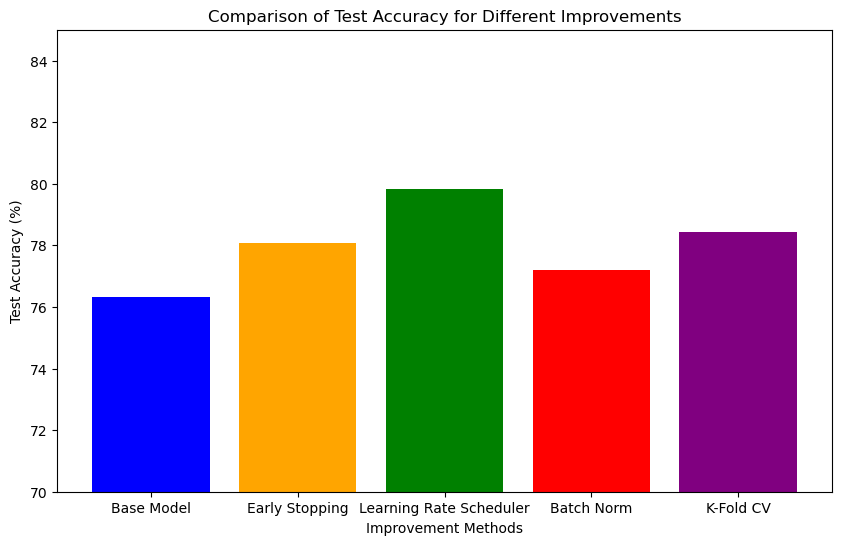

The best model is 'Learning Rate Scheduler' with a test accuracy of 79.82%


In [867]:
# Step 4(b)
# visualization
base_model_accuracy = 76.32
early_stopping_accuracy = 78.07
scheduler_accuracy = 79.82
batch_norm_accuracy = 77.19
kfold_accuracy = 78.42

# Storing the improvement methods and their respective accuracies
improvement_methods = ['Base Model', 'Early Stopping', 'Learning Rate Scheduler', 'Batch Norm', 'K-Fold CV']
test_accuracies = [base_model_accuracy, early_stopping_accuracy, scheduler_accuracy, batch_norm_accuracy, kfold_accuracy]

# Visualizing
plt.figure(figsize=(10, 6))
plt.bar(improvement_methods, test_accuracies, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.title('Comparison of Test Accuracy for Different Improvements')
plt.xlabel('Improvement Methods')
plt.ylabel('Test Accuracy (%)')
plt.ylim(70, 85)
plt.show()

# Finding the best model based on the highest test accuracy
best_accuracy = max(test_accuracies)
best_method = improvement_methods[test_accuracies.index(best_accuracy)]

# Print the best model
print(f"The best model is '{best_method}' with a test accuracy of {best_accuracy:.2f}%")


In [779]:
# Step 4: comparing training time
import time

start_time = time.time()
train_model_with_scheduler(improved_model_learning_rate, train_loader, val_loader, loss_function, optimizer, scheduler, epochs=50)
end_time = time.time()

# time taken
print(f"Training time: {end_time - start_time:.2f} seconds")


Epoch 1, Learning Rate: [5.000000000000002e-09], Train Accuracy: 73.12%, Val Accuracy: 69.30%
Epoch 2, Learning Rate: [5.000000000000002e-09], Train Accuracy: 74.62%, Val Accuracy: 69.30%
Epoch 3, Learning Rate: [5.000000000000002e-09], Train Accuracy: 77.07%, Val Accuracy: 69.30%
Epoch 4, Learning Rate: [5.000000000000002e-09], Train Accuracy: 75.00%, Val Accuracy: 69.30%
Epoch 5, Learning Rate: [5.000000000000002e-09], Train Accuracy: 73.87%, Val Accuracy: 69.30%
Epoch 6, Learning Rate: [5.000000000000002e-09], Train Accuracy: 73.12%, Val Accuracy: 69.30%
Epoch 7, Learning Rate: [5.000000000000002e-09], Train Accuracy: 72.74%, Val Accuracy: 69.30%
Epoch 8, Learning Rate: [5.000000000000002e-09], Train Accuracy: 74.25%, Val Accuracy: 69.30%
Epoch 9, Learning Rate: [5.000000000000002e-09], Train Accuracy: 72.37%, Val Accuracy: 69.30%
Epoch 10, Learning Rate: [5.000000000000002e-10], Train Accuracy: 73.68%, Val Accuracy: 69.30%
Epoch 11, Learning Rate: [5.000000000000002e-10], Train Acc

In [ ]:
# Step 4 (d)
# The best model with highest accuracy is 'Learning Rate Scheduler' model with accuracy 79.70%. 


In [880]:
# Step 5(a): Saving the weight of best model (Learning Rate Scheduler)
torch.save(improved_model_learning_rate.state_dict(), 'gsingh55_assignment2_part_2.pt')
print("Model weights of Best model saved successfully.")


Model weights of Best model saved successfully.


In [787]:
# Step 5(b): Evaluating the performance of the "best model"
from sklearn.metrics import precision_recall_fscore_support

def evaluate_detailed_metrics(model, test_loader):
    all_preds = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = torch.round(outputs)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    print(f"Precision: {precision*100:.2f}%, Recall: {recall*100:.2f}%, F1 Score: {f1_score*100:.2f}%")

evaluate_detailed_metrics(improved_model_learning_rate, test_loader)


Precision: 79.31%, Recall: 57.50%, F1 Score: 66.67%


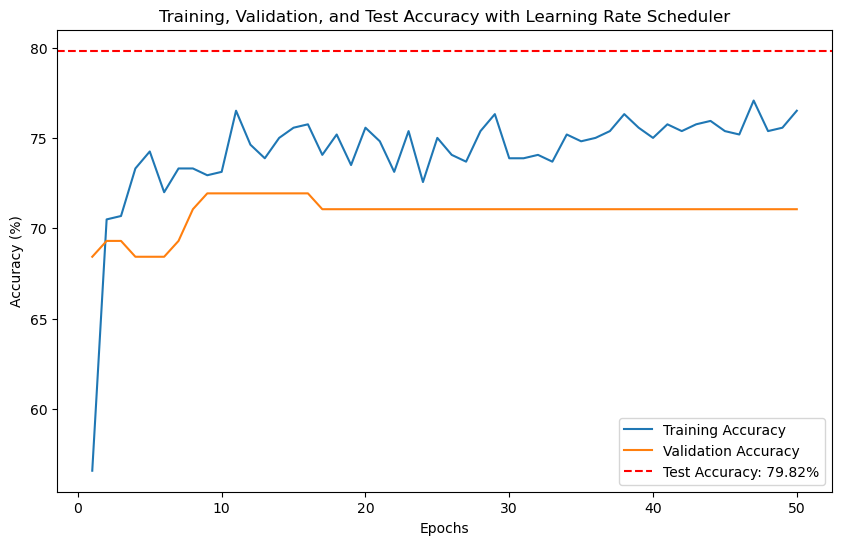

In [831]:
# Step 5(c): visualization
# Plotting Training, Validation, and Test Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), train_accuracies, label='Training Accuracy')
plt.plot(range(1, 51), val_accuracies, label='Validation Accuracy')
plt.axhline(y=test_accuracy_scheduler * 100, color='r', linestyle='--', label=f'Test Accuracy: {test_accuracy_scheduler * 100:.2f}%')
plt.title('Training, Validation, and Test Accuracy with Learning Rate Scheduler')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


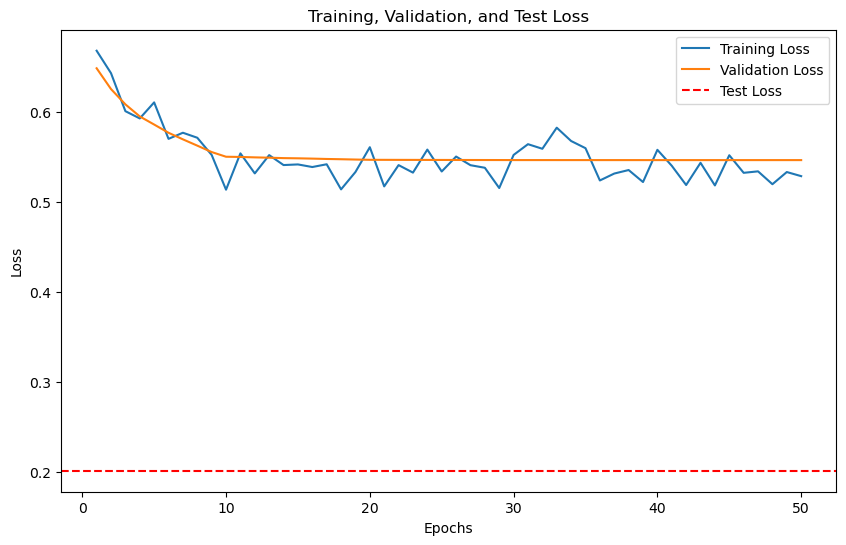

In [833]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), train_losses, label='Training Loss')
plt.plot(range(1, 51), val_losses, label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

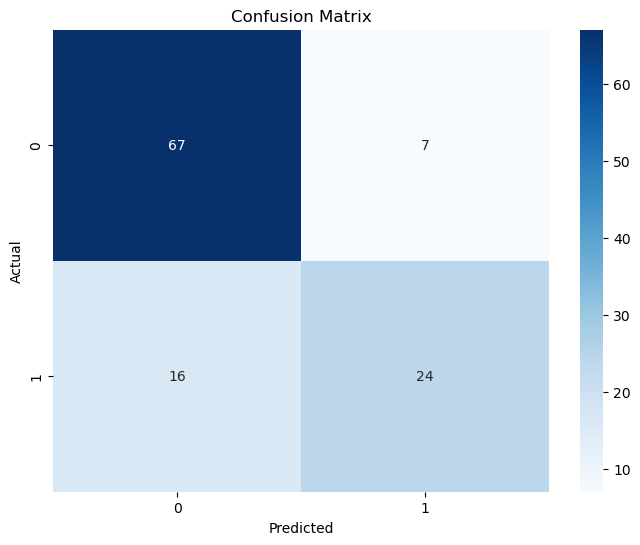

In [837]:
# plotting confusion matrix

# storing predictions and true labels
preds = []
labels = []

improved_model_learning_rate.eval()

# Disabling gradient computation
with torch.no_grad():
    for inputs, label in test_loader:
        outputs = improved_model_learning_rate(inputs)
        predicted = torch.round(outputs)
        preds.extend(predicted.cpu().numpy())
        labels.extend(label.cpu().numpy())

conf_matrix = confusion_matrix(labels, preds)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

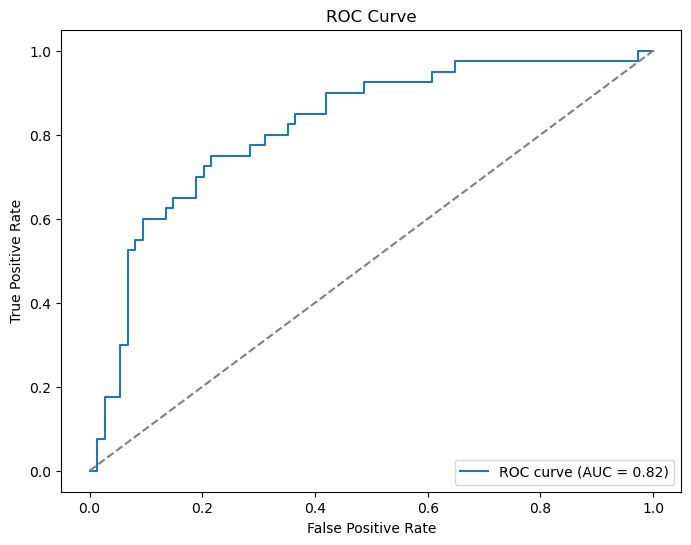

In [839]:
# ROC Curve

improved_model_learning_rate.eval()

# storing predictions and labels
preds = []
labels = []

# Disable gradient calculations because we're in inference mode
with torch.no_grad():
    for inputs, label in test_loader:
        outputs = improved_model_learning_rate(inputs)
        preds.extend(outputs.cpu().numpy())
        labels.extend(label.cpu().numpy())

# ROC curve values and AUC
fpr, tpr, _ = roc_curve(labels, preds)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### References

1. **PyTorch Documentation**
   - [Neural Networks (nn module)](https://pytorch.org/docs/stable/nn.html)
   - [Optimizers in PyTorch](https://pytorch.org/docs/stable/optim.html)
   - [RMSprop Optimizer](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html)
   - [Adam Optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)
   - [PyTorch DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)
   - [PyTorch Autograd](https://pytorch.org/docs/stable/autograd.html)
   - [Saving and Loading Models](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

2. **Seaborn Documentation**
   - [Seaborn Documentation](https://seaborn.pydata.org/)
   - [Seaborn Heatmap (used for Confusion Matrix)](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

3. **Matplotlib Documentation**
   - [Matplotlib Documentation](https://matplotlib.org/stable/contents.html)
   - [Matplotlib Line Plot](https://matplotlib.org/stable/api/pyplot_api.html#matplotlib.pyplot.plot)
   - [Matplotlib Figure API](https://matplotlib.org/stable/api/figure_api.html)

4. **Scikit-Learn Documentation**
   - [Scikit-Learn Metrics (ROC, AUC, Confusion Matrix)](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
   - [ROC Curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
   - [AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html)
   - [Confusion Matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

5. **Torchvision Documentation (for data augmentation if used)**
   - [Torchvision Transforms](https://pytorch.org/vision/stable/transforms.html)

